In [158]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import xarray as xr

import matplotlib.pyplot as plt

from pymc import HalfCauchy, Model, Normal, sample

import warnings
warnings.filterwarnings("ignore")


In [159]:
## Just need two columns.... index and strokes
## Going to try 100, 1000, 10000

## After 30 years of golfing and 1,000 rounds... you tracked your scores

index = 1000 ## Number of samples to have
start = 110 
slope = -0.04  # Adjust for steeper or slower decline
noise = np.random.normal(loc=0, scale=3, size=index)  # Add some randomness

index_l = list(range(1, index + 1))
random_values = np.round(start + slope * np.array(index_l) + noise).astype(int)


df = pd.DataFrame({"index": index_l, "strokes": random_values})
test_size = int(0.1 * len(index_l))  # 10% of the data

data = df[['index', 'strokes']]


random_values

array([106, 107, 112, 107, 114, 110, 111, 107, 105, 109, 105, 108, 113,
       108, 107, 111, 113, 113, 111, 110, 111, 111, 110, 107, 111, 110,
       106, 106, 107, 113, 110, 110, 111, 106, 107, 109, 107, 106, 106,
       107, 109, 102, 112, 110, 112, 107, 108, 105, 105, 106, 106, 107,
       110, 109, 111, 109, 107, 108, 105, 116, 107, 107, 107, 105, 100,
       108, 109, 105, 112, 110, 105, 107, 104, 103, 105, 105, 111, 108,
       107, 107, 108, 107, 112, 105, 104, 110, 102, 102, 110, 106, 101,
       108, 105, 108, 101, 104, 107, 103, 109, 104, 103, 104, 110, 107,
       106, 108, 109, 103, 108, 101, 104, 104, 106, 107, 102, 106, 105,
       105, 108, 105, 108, 105, 107, 109, 106, 107, 102, 108, 107, 112,
       110, 107, 103, 104, 109, 103, 104, 108, 100, 105, 104, 103, 103,
       105, 101, 100, 109, 103, 111, 104, 108, 106, 110, 104, 105,  99,
       100,  99, 108, 107, 105, 104, 106,  98, 104,  94, 105,  99, 104,
       104, 101, 103,  99,  98,  97, 105, 105, 104, 102,  99,  9

In [160]:
##Training Model (Fitting Linear Regression Line)

RANDOM_SEED = 1111
np.random.seed(RANDOM_SEED)

data = df[['index', 'strokes']]

x = data['index'].values
y = data['strokes'].values

x_test = index_l[-test_size:]  # Last 10% for testing
y_test = random_values[-test_size:]

x_train = index_l[:-test_size]  # First 90% for training
y_train = random_values[:-test_size]

with pm.Model() as golf_score_model:
    #data
    time = pm.MutableData("time",x_train)

    #prior
    intercept = pm.Normal("intercept", 0, sigma=20) #y-intercept
    # slope = pm.HalfStudentT("slope", sigma=2, nu=1) ##slope
    slope = pm.Normal("slope", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=11) ##Standard Deviation

    #linear regression line y = mx + b
    mu = (
        intercept + (slope * time)
          )
    
    # Define likelihood
    pm.Normal(
        "GolfScores",
        mu=mu,
        sigma=sigma,
        observed= y_train
        )
    
    ##Sampling
    with golf_score_model:
        idata = pm.sample(draws =500,chains=4,random_seed=RANDOM_SEED)
        idata.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
        idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))
   



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 124 seconds.
The acceptance probability does not match the target. It is 0.7125, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8834, but should be close to 0.8. Try to increase the number of tuning steps.


In [161]:
idata.posterior

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 500)
Coordinates:
  * chain      (chain) int32 0 1 2 3
  * draw       (draw) int32 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables:
    intercept  (chain, draw) float64 109.6 110.0 110.0 ... 109.8 109.8 109.9
    slope      (chain, draw) float64 -0.03902 -0.03953 ... -0.03957 -0.03933
    sigma      (chain, draw) float64 3.025 2.851 3.075 ... 2.966 2.942 2.997
Attributes:
    created_at:                 2025-02-06T00:14:06.777641
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.1.4
    sampling_time:              123.51690244674683
    tuning_steps:               1000

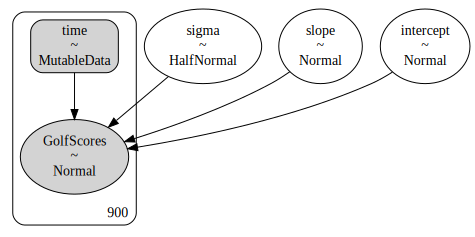

In [162]:
pm.model_to_graphviz(golf_score_model) 

In [163]:
az.summary(idata,round_to=1,var_names=["intercept", "slope"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,109.8,0.2,109.5,110.2,0.0,0.0,966.3,966.0,1.0
slope,-0.0,0.0,-0.0,-0.0,0.0,0.0,932.2,1012.6,1.0


array([<AxesSubplot:title={'center':'intercept'}>,
       <AxesSubplot:title={'center':'slope'}>], dtype=object)

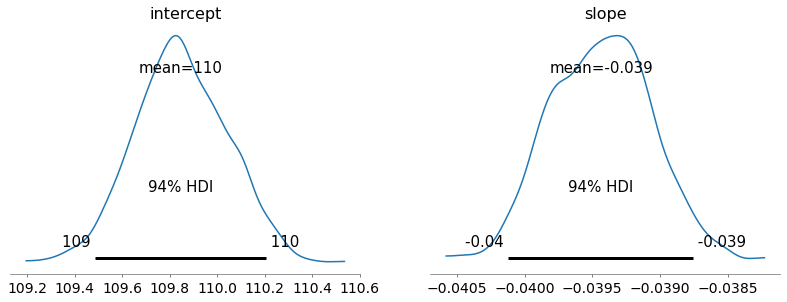

In [164]:
az.plot_posterior(idata, var_names=["intercept", "slope"])

array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

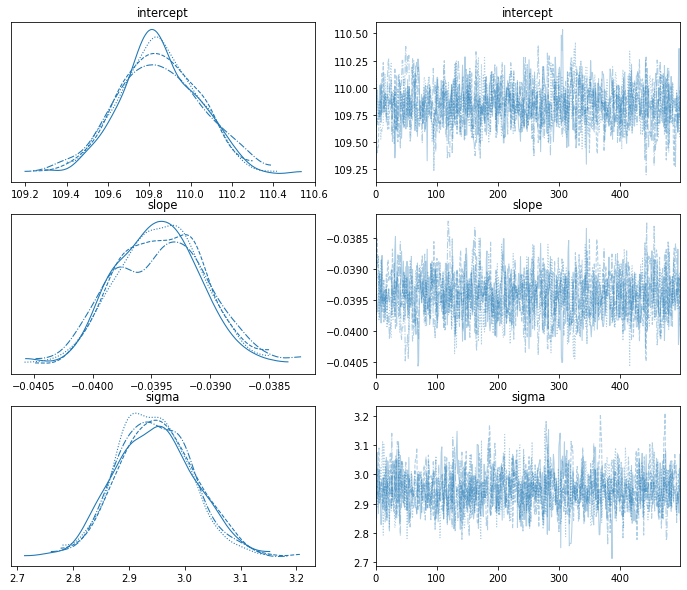

In [165]:
az.plot_trace(idata, figsize=(12, 10))

In [166]:
# Predicting with model
with golf_score_model:
    pm.set_data({"time": x_test})
    predictions = pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED)

posterior_samples = predictions.posterior_predictive['GolfScores']

In [167]:

# Mean prediction (Expected value)
mean_preds = posterior_samples.mean(dim=("chain", "draw"))
print("Mean Preds: ", np.round(mean_preds.values, 2))  # Round to 2 decimal places

# Median prediction
median_preds = posterior_samples.median(dim=("chain", "draw"))
print("Median Preds: ", np.round(median_preds.values, 2))  # Round to 2 decimal places

Mean Preds:  [74.25 74.43 74.29 74.38 74.15 73.93 74.1  74.1  73.92 73.9  73.89 73.8
 73.88 73.8  73.87 73.76 73.7  73.52 73.58 73.6  73.54 73.47 73.44 73.35
 73.44 73.38 73.28 73.26 73.2  73.16 73.11 73.07 73.1  73.02 72.94 72.94
 72.95 72.85 72.77 72.76 72.65 72.68 72.66 72.52 72.62 72.58 72.43 72.42
 72.5  72.34 72.35 72.35 72.26 72.2  72.14 72.18 72.14 72.16 71.98 72.07
 71.97 71.86 71.96 71.78 71.87 71.78 71.76 71.67 71.69 71.6  71.52 71.51
 71.52 71.31 71.35 71.34 71.42 71.31 71.31 71.23 71.11 71.03 71.02 71.12
 70.9  71.06 70.94 70.81 70.8  70.89 70.79 70.82 70.61 70.73 70.5  70.54
 70.6  70.55 70.45 70.45]
Median Preds:  [74.16 74.5  74.23 74.32 74.17 73.89 74.08 74.24 74.   73.97 73.83 73.85
 73.84 73.8  73.96 73.82 73.7  73.5  73.68 73.56 73.53 73.52 73.43 73.27
 73.42 73.39 73.21 73.26 73.2  73.21 73.05 72.99 73.07 72.96 73.05 73.05
 72.9  72.86 72.82 72.87 72.65 72.72 72.67 72.52 72.67 72.59 72.45 72.41
 72.49 72.31 72.36 72.35 72.21 72.18 72.17 72.13 72.13 72.12 71.93 72.0

In [168]:
hdi = az.hdi(predictions.posterior_predictive, hdi_prob=0.99)
print("99% Credible Interval:", hdi['GolfScores'])

99% Credible Interval: <xarray.DataArray 'GolfScores' (GolfScores_dim_0: 100, hdi: 2)>
array([[67.03945794, 81.70673306],
       [66.27718713, 81.54266302],
       [67.20850872, 81.92870588],
       [67.15976887, 81.69030986],
       [66.55700664, 82.02516834],
       [67.2368279 , 81.30753593],
       [66.36930859, 81.91272785],
       [66.52440881, 81.64602521],
       [66.39414335, 81.20718649],
       [67.21729303, 81.64117832],
       [66.07554769, 81.38136924],
       [66.83745726, 81.31802054],
       [66.11230628, 81.4994484 ],
       [65.63298977, 81.24900629],
       [65.45812357, 80.96886136],
       [65.5533778 , 80.42870432],
       [65.65209023, 80.64735305],
       [66.24222926, 81.40710728],
       [66.25115929, 81.39289456],
       [66.53301676, 81.61365823],
...
       [64.14884694, 78.66885573],
       [63.8151373 , 79.46623517],
       [63.91974862, 78.45144807],
       [63.87880255, 78.56718504],
       [64.04431692, 78.09212228],
       [63.51350013, 78.14006673],

In [169]:
hdi = az.hdi(predictions.posterior_predictive, hdi_prob=0.95)
print("95% Credible Interval:", hdi['GolfScores'])
#az.plot_posterior(predictions.posterior_predictive['GolfScores'], hdi_prob=0.95)

95% Credible Interval: <xarray.DataArray 'GolfScores' (GolfScores_dim_0: 100, hdi: 2)>
array([[68.61996755, 79.7111976 ],
       [68.81846471, 80.37274893],
       [68.5861725 , 79.95389678],
       [68.4207866 , 79.99459199],
       [68.49134628, 80.01306507],
       [68.26896931, 79.51533672],
       [68.08428996, 79.61663601],
       [68.39356344, 79.8327225 ],
       [68.54888526, 79.5576123 ],
       [68.48447531, 79.49887311],
       [68.07373748, 79.58802699],
       [68.27024008, 79.64240467],
       [67.94939882, 79.47938879],
       [67.24776494, 79.02630366],
       [68.35661704, 79.78237066],
       [67.99959553, 79.33334239],
       [68.09558849, 79.29624263],
       [67.44128512, 79.36827724],
       [67.64344786, 78.97100267],
       [67.698971  , 79.06587573],
...
       [65.04559413, 76.56740128],
       [65.32741174, 77.34796618],
       [65.60413045, 76.86247546],
       [65.46187853, 76.83781968],
       [64.90532594, 76.35746803],
       [65.74838347, 77.06288688],

In [170]:
hdi = az.hdi(predictions.posterior_predictive, hdi_prob=0.5)
print("50% Credible Interval:", hdi['GolfScores'])
#az.plot_posterior(predictions.posterior_predictive['GolfScores'], hdi_prob=0.5)

50% Credible Interval: <xarray.DataArray 'GolfScores' (GolfScores_dim_0: 100, hdi: 2)>
array([[72.31567305, 76.00264799],
       [72.30691939, 76.12951345],
       [72.10831511, 76.11106698],
       [71.73341487, 75.64477105],
       [72.21999914, 76.11244359],
       [72.24054513, 76.30987332],
       [72.08352544, 75.89295962],
       [72.12602196, 76.09780093],
       [71.9220623 , 75.77289678],
       [72.12360712, 76.09169487],
       [71.63736875, 75.74451589],
       [72.23948629, 76.13228777],
       [72.34374207, 76.10298259],
       [72.09832423, 76.03604847],
       [72.33748687, 76.28883912],
       [72.29423598, 76.42092243],
       [71.84214615, 75.79126643],
       [71.67274385, 75.6587574 ],
       [71.76522756, 75.89977124],
       [71.39592626, 75.4451986 ],
...
       [68.98175237, 72.9619834 ],
       [69.04935391, 73.02877265],
       [69.35069383, 73.14859387],
       [69.55164728, 73.35318118],
       [68.83488445, 72.79123889],
       [69.29062283, 73.23543556],

In [ ]:
future_times = np.arange(max(x_test) + 1, max(x_test) + 51) 

with golf_score_model:
    pm.set_data({"time": future_times})
    future_predictions = pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED)

#predictions_array = future_predictions.posterior_predictive['GolfScores'].values  # Shape: (num_samples, 50)


In [200]:
# Extract predictions (ensure it's a NumPy array)
predictions_array = np.array(future_predictions.posterior_predictive['GolfScores'])

# # Compute statistics (Mean and 95% CI)
# average_predictions = np.mean(predictions_array, axis=0)
# lower_bound = np.percentile(predictions_array, 2.5, axis=0)
# upper_bound = np.percentile(predictions_array, 97.5, axis=0)
# len(lower_bound)

# # Create a DataFrame with future predictions
# df_future = pd.DataFrame({
#     "index": future_times,
#     "average_prediction": average_predictions,
#     "lower_bound": lower_bound,
#     "upper_bound": upper_bound
# })
predictions_array[0][499]

# Print the first few predictions
# print(df_future.head())

array([72.85615016, 68.55067484, 69.7700581 , 67.86075349, 72.58206597,
       67.97212714, 69.89308155, 67.87823086, 67.275453  , 70.24796292,
       65.14270032, 67.60177256, 69.51019887, 69.2953729 , 70.82075602,
       74.92863766, 71.29278107, 68.20711345, 70.71447964, 69.07019903,
       66.9347231 , 71.80693768, 68.90899395, 67.86853188, 74.42908992,
       69.96558254, 68.72200677, 66.86106431, 69.11143329, 69.37937697,
       74.19659281, 68.61501673, 70.38194729, 69.32136961, 73.21112438,
       66.11095584, 67.23356396, 70.63734235, 66.90895129, 71.80944438,
       64.81392866, 66.92191622, 70.56466413, 70.30033953, 70.4269221 ,
       67.81328737, 60.85983407, 68.23908996, 71.92810203, 67.7239688 ])

In [187]:
predictions_array

array([[[66.12874476, 66.14323387, 72.53558419, ..., 72.56191214,
         68.0913551 , 68.88510398],
        [67.4452386 , 73.88889722, 70.65079582, ..., 71.62225541,
         74.1450244 , 70.47727978],
        [68.67230793, 69.2680252 , 70.98440336, ..., 71.81959541,
         72.20282037, 67.99489031],
        ...,
        [68.25898025, 67.79446937, 68.97608853, ..., 68.95726051,
         69.42125689, 66.18748781],
        [74.65898434, 69.98669146, 72.43237203, ..., 68.08224921,
         71.43493068, 65.11326733],
        [72.85615016, 68.55067484, 69.7700581 , ..., 68.23908996,
         71.92810203, 67.7239688 ]],

       [[69.41403926, 70.30602192, 69.10663121, ..., 66.69812798,
         66.42714002, 66.3163871 ],
        [68.16847664, 68.13930604, 76.45729495, ..., 66.5388558 ,
         72.14615696, 71.23958876],
        [74.0562972 , 72.09075448, 70.38855085, ..., 71.26563051,
         71.21544206, 66.43032275],
        ...,
        [69.46513264, 76.37591702, 73.10896808, ..., 6

In [ ]:
print(len(predictions_array))  # chains 
print(len(predictions_array[0])) # draws
print(len(predictions_array[1]))
print(len(predictions_array[2]))
print(len(predictions_array[3]))
print(len(predictions_array[4]))

4
500
500
500
500


IndexError: index 4 is out of bounds for axis 0 with size 4